In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import random
from scipy import stats

# Load and prepare data
btc = pd.read_csv('BTC-USD_Historical.csv')
btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc[(btc['Date'] >= '2016-07-09') & (btc['Date'] <= '2018-04-5')].sort_values('Date').reset_index(drop=True)
btc

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-07-09,666.383972,666.383972,633.398987,650.960022,650.960022,180536000
1,2016-07-10,650.598999,652.294006,641.263977,649.359985,649.359985,102532000
2,2016-07-11,648.484009,659.629028,644.979980,647.658997,647.658997,107910000
3,2016-07-12,648.283020,675.258972,646.778992,664.551025,664.551025,138172992
4,2016-07-13,664.796997,668.700012,654.468018,654.468018,654.468018,131449000
...,...,...,...,...,...,...,...
631,2018-04-01,7003.060059,7060.950195,6526.870117,6844.229980,6844.229980,4532100096
632,2018-04-02,6844.859863,7135.470215,6816.580078,7083.799805,7083.799805,4333440000
633,2018-04-03,7102.259766,7530.939941,7072.490234,7456.109863,7456.109863,5499700224
634,2018-04-04,7456.410156,7469.879883,6803.879883,6853.839844,6853.839844,4936000000


In [2]:
# Strategy parameters
INITIAL_MARGIN = 1  # BTC collateral per cycle
LEVERAGE = 2
MAX_NOTIONAL = INITIAL_MARGIN * LEVERAGE  
ANNUAL_FEE_RATE = 0.10
DAILY_FEE = ANNUAL_FEE_RATE/365.0

def ladder(delta_pct):
    if delta_pct > 0:
        return 0.00 * INITIAL_MARGIN, 0.0
    if delta_pct > -0.05:
        return 0.01 * INITIAL_MARGIN, 0.0
    if delta_pct > -0.10:
        return 0.02 * INITIAL_MARGIN, 0.0
    if delta_pct > -0.15:
        return 0.03 * INITIAL_MARGIN, 0.0
    if delta_pct > -0.20:
        return 0.04 * INITIAL_MARGIN, 0.0
    if delta_pct > -0.40:  # Covers the range between -0.40 and -0.20
        return 0.05 * INITIAL_MARGIN, 0.0
    
    if delta_pct > -0.60:  # Covers the range between -0.60 and -0.40
        return 0.1 * INITIAL_MARGIN, 0.0
    return 0.0, 0.0

def liquidation_price(entry, leverage, maintenance_margin=0.005):
    return entry * (1 - (1/leverage) + maintenance_margin)
    
# Initialize state variables
margin = 0.0
spot = 0.0
pos_margin = 0.0
pos_notional = 0.0
avg_price = None
in_cycle = False
liquidated = False
cycle_num = 0

# Track results
records = []
starts, ends = [], []
cycle_details = []  # Store detailed cycle information

# Run backtest
np.random.seed(42)
random.seed(42)

In [3]:
for idx, row in btc.iterrows():
    date = row['Date']
    low, high, close = row['Low'], row['High'], row['Close']
    
    # Start new cycle if needed
    if not in_cycle and not liquidated:
        margin = INITIAL_MARGIN
        open_margin = 0.02 * INITIAL_MARGIN
        fill_price = random.uniform(low, high)
        pos_margin = open_margin
        margin -= open_margin
        pos_notional = pos_margin * LEVERAGE
        avg_price = fill_price
        in_cycle = True
        starts.append(date)
        cycle_num += 1  # Increment cycle number at start
        liq_price = liquidation_price(avg_price, LEVERAGE)

        # Record cycle start details
        cycle_details.append({
            'cycle': cycle_num,
            'start_date': date,
            'start_price': fill_price,
            'start_margin': margin,
            'start_spot': spot,
            'start_pos_margin': pos_margin,
            'start_pos_notional': pos_notional,
            'start_equity_btc': margin + spot + pos_margin
        })

    # Apply daily funding fee and subtract from margin
    # Change 1: Ensure fee impacts margin to reflect cost of leverage
    if pos_notional > 0:
        fee = pos_notional * DAILY_FEE
        margin -= fee / close  # Convert fee from USD to BTC and subtract from margin
    else:
        fee = 0.0

    # Update liquidation price daily based on current avg_price
    # Change 2: Moved liq_price calculation here to update every day
    if in_cycle:
        liq_price = liquidation_price(avg_price, LEVERAGE)

    base_equity_btc = margin + spot + pos_margin
    unreal_pnl_usd = pos_notional * (close - avg_price) if in_cycle else 0.0
    base_equity_usd = base_equity_btc * close
    equity_usd = base_equity_usd + unreal_pnl_usd
    
    # Record daily state
    records.append({
        'Date': date,
        'Close': close,
        'Equity_USD': equity_usd,
        'Margin_BTC': margin,
        'Margin_USD': margin * close,
        'Spot_USD': spot*close,
        'Spot_BTC': spot,
        'Pos_Margin_BTC': pos_margin,
        'Pos_Margin_USD': pos_margin * close,
        'Pos_Notional_USD': pos_notional * close,
        'Pos_Notional_BTC': pos_notional,        
        'Base_Equity_BTC': base_equity_btc,
        'unreal_pnl_USD': unreal_pnl_usd,
        'unreal_pnl_BTC': unreal_pnl_usd / close if close > 0 else 0,
        'avg_price': avg_price if in_cycle else 0,
        'avg_price_BTC': avg_price/close if in_cycle and close > 0 else 0,
        'liq_price': liq_price if in_cycle else 0,
        'Cycle': cycle_num if in_cycle else 0
    })
    
    # Check for liquidation
    if in_cycle and low <= liq_price:
        # Record liquidation details
        cycle_details[-1].update({
            'end_date': date,
            'end_price': close,
            'end_margin': 0,
            'end_spot': 0,
            'end_pos_margin': 0,
            'end_pos_notional': 0,
            'end_equity_btc': 0,
            'reason': 'LIQUIDATION',
            'duration_days': (date - cycle_details[-1]['start_date']).days
        })

        # Reset all values to zero on liquidation
        margin = 0
        spot = 0
        pos_margin = 0
        pos_notional = 0
        liquidated = True
        in_cycle = False
        ends.append(date)
        break  # Stop backtest at liquidation
    
    if not in_cycle:
        continue  # Skip if not in a cycle
    
    # Take-profit check (15% above average entry)
    if close >= avg_price * 1.10:
        # Calculate realized PnL in BTC
        realized_pnl_btc = pos_notional * (close - avg_price) / close
        
        # Return position margin and add realized PnL
        margin += pos_margin + realized_pnl_btc
        
        # Sweep excess margin to spot
        if margin > INITIAL_MARGIN:
            spot += (margin - INITIAL_MARGIN)
            margin = INITIAL_MARGIN
        
        # Record TP details
        cycle_details[-1].update({
            'end_date': date,
            'end_price': close,
            'end_margin': margin,
            'end_spot': spot,
            'end_pos_margin': 0,
            'end_pos_notional': 0,
            'end_equity_btc': margin + spot,
            'reason': 'TAKE-PROFIT',
            'duration_days': (date - cycle_details[-1]['start_date']).days
        })
        
        # Reset position
        pos_margin = 0.0
        pos_notional = 0.0
        avg_price = None
        in_cycle = False
        ends.append(date)
        continue
    
    # Daily add logic
    delta = (close - avg_price) / avg_price if avg_price is not None and avg_price > 0 else 0
    add_margin, extra = ladder(delta)
    
    # Cap by available margin
    add_margin = min(add_margin, margin)
    
    # Adjust if would exceed max notional
    if add_margin > 0:
        add_notional = add_margin * LEVERAGE
        if pos_notional + add_notional > MAX_NOTIONAL:
            add_notional = MAX_NOTIONAL - pos_notional
            add_margin = add_notional / LEVERAGE
        
        if add_notional > 0:  # Only update if we're actually adding
                # Correct weighted average calculation
                # pos_notional is in BTC, avg_price is USD/BTC, close is USD/BTC
                total_usd_value = pos_notional * avg_price + add_notional * close
                new_notional = pos_notional + add_notional
                avg_price = total_usd_value / new_notional
                
                pos_notional = new_notional
                pos_margin += add_margin
                margin -= add_margin
    
    # Extra margin injection at -40%
    if extra > 0:
        margin += extra

# ### CHANGE FOR DATE RANGE AND FORCED CLOSE ### Force close any open trade on the last day (2022-02-02)
    if in_cycle and date == btc['Date'].iloc[-1]:
        # Calculate realized PnL in BTC (could be positive or negative)
        realized_pnl_btc = pos_notional * (close - avg_price) / close
        
        # Return position margin and add realized PnL to margin
        margin += pos_margin + realized_pnl_btc
        
        # Sweep excess margin to spot if above initial margin
        if margin > INITIAL_MARGIN:
            spot += (margin - INITIAL_MARGIN)
            margin = INITIAL_MARGIN
        
        # Record forced close details
        cycle_details[-1].update({
            'end_date': date,
            'end_price': close,
            'end_margin': margin,
            'end_spot': spot,
            'end_pos_margin': 0,
            'end_pos_notional': 0,
            'end_equity_btc': margin + spot,
            'reason': 'FORCED-CLOSE (END DATE)',
            'duration_days': (date - cycle_details[-1]['start_date']).days
        })
        
        # Reset position
        pos_margin = 0.0
        pos_notional = 0.0
        avg_price = None
        in_cycle = False
        ends.append(date)


Cycle Details:
Cycle  Start Date   End Date     Reason       Days  Start Equity End Equity   Start Price  End Price    BTC Change  
------------------------------------------------------------------------------------------------------------------------
1      2016-07-09   2016-10-22   TAKE-PROFIT  105   1.000000 BTC  1.096683 BTC  $654.49       $657.29       +0.096683 BTC
2      2016-10-23   2016-11-01   TAKE-PROFIT  9     1.096683 BTC  1.102917 BTC  $654.07       $729.79       +0.006234 BTC
3      2016-11-02   2016-12-02   TAKE-PROFIT  30    1.102917 BTC  1.121561 BTC  $727.43       $777.94       +0.018644 BTC
4      2016-12-03   2016-12-22   TAKE-PROFIT  19    1.121561 BTC  1.130804 BTC  $767.85       $864.54       +0.009242 BTC
5      2016-12-23   2017-01-01   TAKE-PROFIT  9     1.130804 BTC  1.138414 BTC  $909.19       $998.33       +0.007611 BTC
6      2017-01-02   2017-01-04   TAKE-PROFIT  2     1.138414 BTC  1.143075 BTC  $1,020.18     $1,154.73     +0.004661 BTC
7      2017-01

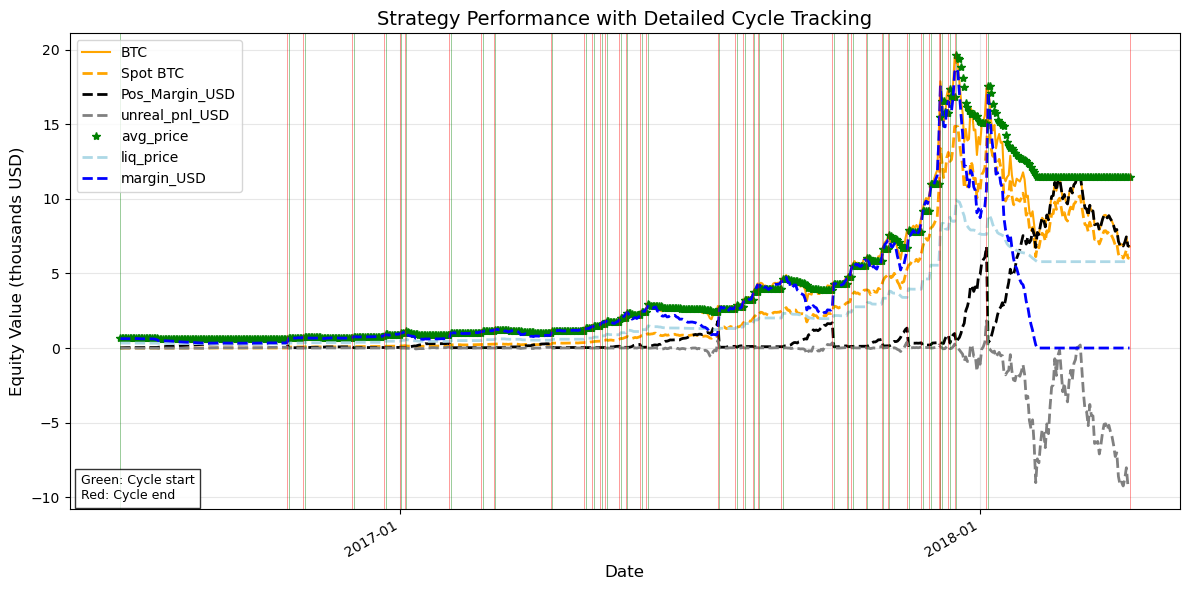


Strategy completed without liquidation

Performance Summary:
Initial Equity: $650.82
Final Equity: $3,495.60
Total Return: 437.11%
Cumulative Return: 437.11%
CAGR: 162.81%
Sharpe Ratio: 1.4078
Risk (Annualized Volatility): 162.55%
Max Drawdown: -89.91%
Cycles Completed: 39
Liquidated: No

Statistical Significance of Returns:
Based on: Cycle Returns (n=39)
T-Statistic: 2.7957
P-Value: 0.0081
Statistically Significant (at 5% level): Yes
Note: Small sample size of cycles may limit reliability of statistical significance.


In [4]:
# Convert records to DataFrame
perf = pd.DataFrame(records)

# Print cycle details in a readable format
print("\nCycle Details:")
print("="*120)
print(f"{'Cycle':<6} {'Start Date':<12} {'End Date':<12} {'Reason':<12} {'Days':<5} {'Start Equity':<12} {'End Equity':<12} {'Start Price':<12} {'End Price':<12} {'BTC Change':<12}")
print("-"*120)

for cycle in cycle_details:
    start_eq = cycle['start_equity_btc']
    end_eq = cycle['end_equity_btc']
    btc_change = end_eq - start_eq
    
    print(f"{cycle['cycle']:<6} "
          f"{cycle['start_date'].strftime('%Y-%m-%d'):<12} "
          f"{cycle['end_date'].strftime('%Y-%m-%d'):<12} "
          f"{cycle['reason']:<12} "
          f"{cycle['duration_days']:<5} "
          f"{start_eq:.6f} BTC  "
          f"{end_eq:.6f} BTC  "
          f"${cycle['start_price']:<12,.2f} "
          f"${cycle['end_price']:<12,.2f} "
          f"{btc_change:+.6f} BTC")

# Print details of the last cycle
if cycle_details:
    last_cycle = cycle_details[-1]
    print("\nLast Cycle Details:")
    print("="*60)
    print(f"Cycle Number: {last_cycle['cycle']}")
    print(f"Start Date: {last_cycle['start_date'].strftime('%Y-%m-%d')}")
    print(f"End Date: {last_cycle['end_date'].strftime('%Y-%m-%d')}")
    print(f"Reason: {last_cycle['reason']}")
    print(f"Duration: {last_cycle['duration_days']} days")
    print(f"Start Price: ${last_cycle['start_price']:,.2f}")
    print(f"End Price: ${last_cycle['end_price']:,.2f}")
    print(f"Price Change: {(last_cycle['end_price']/last_cycle['start_price']-1)*100:.2f}%")
    print(f"Start Equity: {last_cycle['start_equity_btc']:.6f} BTC")
    print(f"End Equity: {last_cycle['end_equity_btc']:.6f} BTC")
    print(f"BTC Change: {last_cycle['end_equity_btc'] - last_cycle['start_equity_btc']:+.6f} BTC")
    
    # Explanation of last cycle
    if last_cycle['reason'] == 'LIQUIDATION':
        start_price = last_cycle['start_price']
        end_price = last_cycle['end_price']
        price_drop = (start_price - end_price)/start_price
        print("\nWhy liquidation happened:")
        print(f"- Price dropped from ${start_price:,.2f} to ${end_price:,.2f} "
              f"({price_drop*100:.2f}% decrease)")
        print("- The strategy kept adding to losing positions as price fell")
        print("- Daily funding fees accumulated and drained margin")
        print("- When price fell significantly below average entry, ", "unrealized losses exceeded the account value")
        print("- This triggered the liquidation condition (equity <= 0)")

# Create plot
plt.figure(figsize=(12, 6))
#plt.plot(perf['Date'], perf['Equity_USD'] / 1000, label='Strategy Equity', color='blue', linewidth=1.5)
plt.plot(perf['Date'], 1 * perf['Close'] / 1000, label='BTC', color='orange', linewidth=1.5)

plt.plot(perf['Date'], perf['Spot_USD']/1000, '--', label='Spot BTC', color='orange', linewidth=2)
plt.plot(perf['Date'], perf['Pos_Margin_USD']/1000, '--', label='Pos_Margin_USD', color='black', linewidth=2)
#plt.plot(perf['Date'], perf['Pos_Notional_USD']/1000, '--', label='Pos_Notional_USD', color='red', linewidth=2)
plt.plot(perf['Date'], perf['unreal_pnl_USD']/1000, '--', label='unreal_pnl_USD', color='grey', linewidth=2)
plt.plot(perf['Date'], perf['avg_price']/1000, '*', label='avg_price', color='green', linewidth=0.5)
plt.plot(perf['Date'], perf['liq_price']/1000, '--', label='liq_price', color='lightblue', linewidth=2)

plt.plot(perf['Date'], perf['Margin_USD']/1000, '--', label='margin_USD', color='blue', linewidth=2)


# Add cycle markers
for start_date in starts:
    plt.axvline(start_date, color='green', alpha=0.4, linewidth=0.7)
for end_date in ends:
    plt.axvline(end_date, color='red', alpha=0.4, linewidth=0.7)

# Format plot
plt.title('Strategy Performance with Detailed Cycle Tracking', fontsize=14)
plt.ylabel('Equity Value (thousands USD)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.text(0.01, 0.02, 'Green: Cycle start\nRed: Cycle end', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8), fontsize=9)
plt.tight_layout()
plt.show()

# Print liquidation status
if liquidated:
    print(f"\nStrategy was liquidated on {ends[-1].strftime('%Y-%m-%d')} in Cycle {cycle_num}")
else:
    print("\nStrategy completed without liquidation")

if not perf.empty:
    init_eq = perf['Equity_USD'].iloc[0]
    final_eq = perf['Equity_USD'].iloc[-1]
    ret = (final_eq/init_eq -1)*100
    num_days = (perf['Date'].iloc[-1]-perf['Date'].iloc[0]).days
    cagr = (final_eq/init_eq)**(365/num_days)-1 if num_days > 0 else 0
    perf['Return'] = perf['Equity_USD'].pct_change()
    sharpe = perf['Return'].mean()/perf['Return'].std()*math.sqrt(365) if perf['Return'].std() != 0 else np.nan
    cum_returns = (1 + perf['Return']).cumprod() - 1
    final_cum_return = cum_returns.iloc[-1] * 100 if not cum_returns.empty else 0
    risk_volatility = perf['Return'].std() * math.sqrt(365) * 100 if perf['Return'].std() != 0 else 0
    cum_max = perf['Equity_USD'].cummax()
    max_dd = ((perf['Equity_USD']-cum_max)/cum_max).min()*100
    
    # ### CHANGE FOR STATISTICAL SIGNIFICANCE ### Calculate statistical significance of returns
    # First, try using cycle returns if multiple cycles exist
    cycle_returns = []
    for cycle in cycle_details:
        start_eq = cycle['start_equity_btc'] * cycle['start_price']  # Convert to USD
        end_eq = cycle['end_equity_btc'] * cycle['end_price']  # Convert to USD
        if start_eq > 0:
            cycle_ret = (end_eq / start_eq) - 1
            cycle_returns.append(cycle_ret)
    
    # If we have multiple cycle returns, test their significance
    if len(cycle_returns) > 1:
        t_stat, p_value = stats.ttest_1samp(cycle_returns, 0)
        significance_note = f"Cycle Returns (n={len(cycle_returns)})"
        sample_size_note = "Note: Small sample size of cycles may limit reliability of statistical significance."
    else:
        # Fallback to daily returns if cycles are too few
        daily_returns = perf['Return'].dropna()
        t_stat, p_value = stats.ttest_1samp(daily_returns, 0)
        significance_note = f"Daily Returns (n={len(daily_returns)})"
        sample_size_note = "Note: Using daily returns due to limited cycles; long holding periods may skew results."
    
    # Interpret p-value for significance
    significance_level = 0.05
    is_significant = p_value < significance_level

    print("\nPerformance Summary:")
    print(f"Initial Equity: ${init_eq:,.2f}")
    print(f"Final Equity: ${final_eq:,.2f}")
    print(f"Total Return: {ret:.2f}%")
    print(f"Cumulative Return: {final_cum_return:.2f}%")
    print(f"CAGR: {cagr*100:.2f}%" if num_days > 0 else "CAGR: N/A")
    print(f"Sharpe Ratio: {sharpe:.4f}")
    print(f"Risk (Annualized Volatility): {risk_volatility:.2f}%")
    print(f"Max Drawdown: {max_dd:.2f}%")
    print(f"Cycles Completed: {len(cycle_details)}")
    print(f"Liquidated: {'Yes' if liquidated else 'No'}")
    # ### CHANGE FOR STATISTICAL SIGNIFICANCE ### Output statistical significance results
    print("\nStatistical Significance of Returns:")
    print(f"Based on: {significance_note}")
    print(f"T-Statistic: {t_stat:.4f}")
    print(f"P-Value: {p_value:.4f}")
    print(f"Statistically Significant (at {significance_level*100:.0f}% level): {'Yes' if is_significant else 'No'}")
    print(sample_size_note)

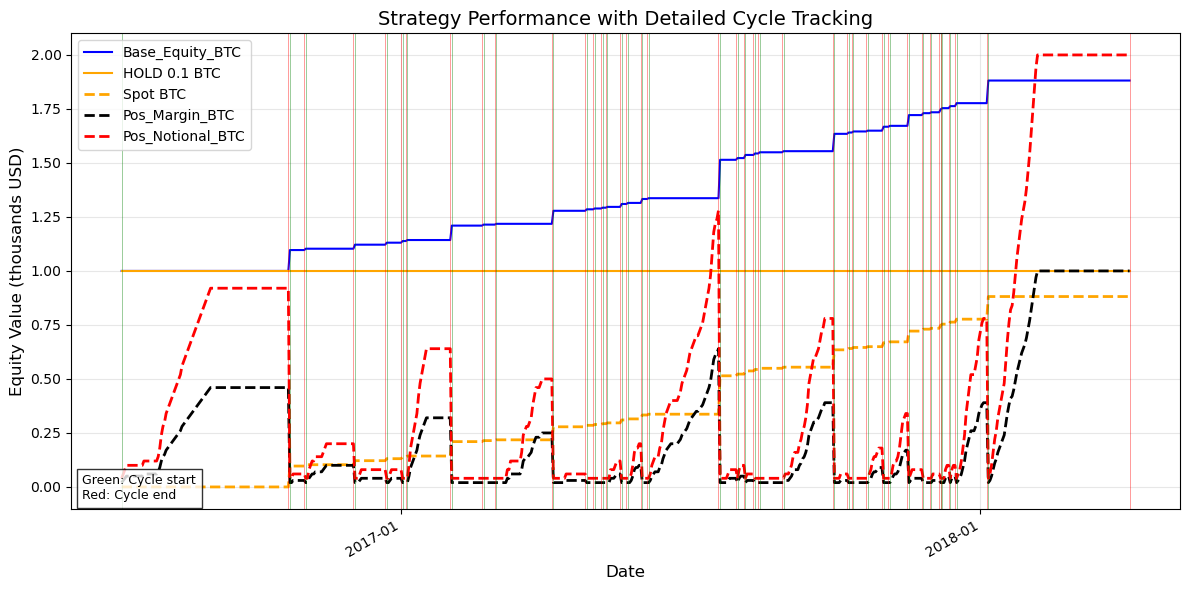

In [5]:
# Create plot
plt.figure(figsize=(12, 6))
plt.plot(perf['Date'], perf['Base_Equity_BTC'], label='Base_Equity_BTC', color='blue', linewidth=1.5)
plt.plot(perf['Date'], [1]*len(perf['Date']), label='HOLD 0.1 BTC', color='orange', linewidth=1.5)

plt.plot(perf['Date'], perf['Spot_BTC'], '--', label='Spot BTC', color='orange', linewidth=2)
plt.plot(perf['Date'], perf['Pos_Margin_BTC'], '--', label='Pos_Margin_BTC', color='black', linewidth=2)
plt.plot(perf['Date'], perf['Pos_Notional_BTC'], '--', label='Pos_Notional_BTC', color='red', linewidth=2)

# Add cycle markers
for start_date in starts:
    plt.axvline(start_date, color='green', alpha=0.4, linewidth=0.7)
for end_date in ends:
    plt.axvline(end_date, color='red', alpha=0.4, linewidth=0.7)

# Format plot
plt.title('Strategy Performance with Detailed Cycle Tracking', fontsize=14)
plt.ylabel('Equity Value (thousands USD)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.text(0.01, 0.02, 'Green: Cycle start\nRed: Cycle end', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8), fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
# Print summary metrics
init_eq = perf['Equity_USD'].iloc[0]
final_eq = perf['Equity_USD'].iloc[-1]
ret = (final_eq/init_eq -1)*100
num_days = (perf['Date'].iloc[-1]-perf['Date'].iloc[0]).days
cagr = (final_eq/init_eq)**(365/num_days)-1 if num_days > 0 else 0
perf['Return'] = perf['Equity_USD'].pct_change()
sharpe = perf['Return'].mean()/perf['Return'].std()*math.sqrt(365) if perf['Return'].std() != 0 else np.nan
cum_max = perf['Equity_USD'].cummax()
max_dd = ((perf['Equity_USD']-cum_max)/cum_max).min()*100

print("\nPerformance Summary:")
print(f"Initial Equity: ${init_eq:,.2f}")
print(f"Final Equity: ${final_eq:,.2f}")
print(f"Total Return: {ret:.2f}%")
print(f"CAGR: {cagr*100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Max Drawdown: {max_dd:.2f}%")
print(f"Cycles Completed: {len(ends)}")
print(f"Liquidated: {'Yes' if liquidated else 'No'}")


Performance Summary:
Initial Equity: $650.82
Final Equity: $3,495.60
Total Return: 437.11%
CAGR: 162.81%
Sharpe Ratio: 1.4078
Max Drawdown: -89.91%
Cycles Completed: 39
Liquidated: No


: 